# --- Day 21: Chronal Conversion ---

You should have been watching where you were going, because as you wander the new North Pole base, you trip and fall into a very deep hole!

Just kidding. You're falling through time again.

If you keep up your current pace, you should have resolved all of the temporal anomalies by the next time the device activates. Since you have very little interest in browsing history in 500-year increments for the rest of your life, you need to find a way to get back to your present time.

After a little research, you discover two important facts about the behavior of the device:

First, you discover that the device is hard-wired to always send you back in time in 500-year increments. Changing this is probably not feasible.

Second, you discover the activation system (your puzzle input) for the time travel module. Currently, it appears to run forever without halting.

If you can cause the activation system to halt at a specific moment, maybe you can make the device send you so far back in time that you cause an integer underflow in time itself and wrap around back to your current time!

The device executes the program as specified in manual section one and manual section two.

Your goal is to figure out how the program works and cause it to halt. You can only control register 0; every other register begins at 0 as usual.

Because time travel is a dangerous activity, the activation system begins with a few instructions which verify that bitwise AND (via bani) does a numeric operation and not an operation as if the inputs were interpreted as strings. If the test fails, it enters an infinite loop re-running the test instead of allowing the program to execute normally. If the test passes, the program continues, and assumes that all other bitwise operations (banr, bori, and borr) also interpret their inputs as numbers. (Clearly, the Elves who wrote this system were worried that someone might introduce a bug while trying to emulate this system with a scripting language.)

What is the lowest non-negative integer value for register 0 that causes the program to halt after executing the fewest instructions? (Executing the same instruction multiple times counts as multiple instructions executed.)


```
#ip 4

Test() [passes for my Day 19 implementation)

 0: seti 123 0 1
 1: bani 1 456 1
 2: eqri 1 72 1
 3: addr 1 4 4
 4: seti 0 0 4

Main()

 5: seti 0 3 1          r1 = 0
 6: bori 1 65536 5      r5 = r1 | 65536  # set bit 17
 7: seti 8586263 3 1    r1 = 8586263 # 0b 10000011 00000100 00010111 0x830417
 
 8: bani 5 255 2        r2 = r5 & 255 (r2 = last 8 bits of r5 :- r5 % 256)
 9: addr 1 2 1          r1 = r1 + r2
10: bani 1 16777215 1   r1 = r1 & 16777215 (last 24 bits)
11: muli 1 65899 1      r1 = r1 * 65899
12: bani 1 16777215 1   r1 = r1 & 16777215 (last 24 bits)
13: gtir 256 5 2        if 256 > r5: #r2 = 1 else r2 = 0
14: addr 2 4 4              then goto 28: (via 16:)
15: addi 4 1 4              else goto 17:
16: seti 27 8 4                 (goto 28:)

17: seti 0 1 2          r2 = 0

18: addi 2 1 3          r3 = r2 + 1
19: muli 3 256 3        r3 = r3 * 256
20: gtrr 3 5 3          if r3 > r5
21: addr 3 4 4              then goto 26:
22: addi 4 1 4              else goto 24:
23: seti 25 8 4                  (goto 26:)
24: addi 2 1 2          r2 = r2 + 1
25: seti 17 7 4         goto 18:

26: setr 2 0 5          r5 = r2
27: seti 7 8 4          goto 8:

28: eqrr 1 0 2          if r1 == r0
29: addr 2 4 4              then HALT
30: seti 5 4 4              else goto 6:
```

Python pseudocode...
```Python
r0 = whatever_we_want_to_test
r1 = 0
while True: # 6 <-> 30
    r5 = r1 | 65536 # set bit 17 to 1
    r1 = 8586263
    
    #8
    whie True:
        r2 = r5 % 256
        r1 = r1 + r2
        r1 = r1 % 16777216 # trim to 24 bits
        r1 = r1 * 65899
        r1 = r1 % 16777216 # trim to 24 bits

        if r5 <= 256:
            if r1 == r0: # What's the minimum r1 can be when the program gets here?
                break # HALT!
            else:
                continue

        r2 = 0

        #18
        while r3 <= r5:
            r3 = r2 + 1
            r3 = r3 * 256
            r2 = r2 + 1
        r5 = r2
        
```

## What's going on with those constants?


Firstly - 16777215 is a 24-bit mask -  0b111111111111111111111111

In [1]:
print(f'{16777215:b}')

111111111111111111111111


In [2]:
16777216 / 65899

254.5898420309868

Therefore the first time the multiplication in line 11 wraps over the 24 bit boundary will be when r1 = 255.  The resulting value will be:-

In [3]:
(255 * 65899) & 16777215

27029

What about 8586263?

In [4]:
f'{8586263:b}'

'100000110000010000010111'

In [5]:
8586263 / 65899

130.29428367653531

# Investigations using the elfcode debugger

values of r1 at 28: (determined by running the VM with a breakpoint via `elfcodedbg.py`)

5970144
3580534
8432838
12585694
12801108
9919462
1628135
4215596
8008671
1719558
724421
1758802
9836282
4280966
5744212
6005252



In [36]:
l = [5970144, 3580534, 8432838, 12585694, 12801108, 9919462, 1628135, 4215596, 8008671, 1719558, 724421, 1758802, 9836282, 4280966, 5744212, 6005252]

In [38]:
list(map(lambda t: (t[0] - t[1]), zip(l, l[1:]))) # differences

[2389610,
 -4852304,
 -4152856,
 -215414,
 2881646,
 8291327,
 -2587461,
 -3793075,
 6289113,
 995137,
 -1034381,
 -8077480,
 5555316,
 -1463246,
 -261040]

In [39]:
65899 - 65535

364

In [40]:
[i % 65535 for i in l]

[6459,
 41644,
 44358,
 2974,
 21783,
 23677,
 55295,
 21356,
 13401,
 15648,
 3536,
 54892,
 6032,
 21191,
 42667,
 41567]

# Solution with Elfcode manually translated to Python

In [44]:
values = []
part1 = True

r0 = 0
r1 = r2 = r3 = r4 = r5 = 0


#r1 = 0
try:
    while True: # 6 <-> 30
        r5 = r1 | 65536 # set bit 17 to 1
        r1 = 8586263

        #print(f'regs = {r0, r1, r2, r3, r4, r5}')
        #8
        while True:
            r2 = r5 % 256
            r1 = r1 + r2
            r1 = r1 % 16777216 # trim to 24 bits
            r1 = r1 * 65899
            r1 = r1 % 16777216 # trim to 24 bits

            if r5 < 256:
    #            if r1 == r0: # What's the minimum r1 can be when the program gets here?
                if True:
                    #print(f'found a value: r1 = {r1}')
                    if r1 in values:
                        print(f'Part 2 answer is {values[-1]}')
                        print(f'(Repeat value was {r1})')
                        raise ValueError # use a random exception to HALT!
                    else:
                        # store and reset
                        values.append(r1)
                        if part1:
                            part1 = False
                            print (f'Part 1 answer is {r1}')
                        #print('.', end='')
                        #sys.stdout.flush()
                        #r0 = r1 = r2 = r3 = r4 = r5 = 0
                        break
                else:
                    break

            r2 = 0

            #18
    #         while r3 <= r5:
    #             r3 = r2 + 1
    #             r3 = r3 * 256
    #             r2 = r2 + 1
    #         r5 = r2
            r5 = r5 // 256 # optimisation of block above
except ValueError:
    pass

Part 1 answer is 5970144
Part 2 answer is 13943296
(Repeat value was 14833070)


In [21]:
len(values)

10310

In [52]:
len(values[values.index(14833070):]) # length of repeating part of the sequence

6954

# What's going on?

The program looks to be a PRNG, with a cycle length (for my input) of 6954

In [23]:
values[:16]

[5970144,
 3580534,
 8432838,
 12585694,
 12801108,
 9919462,
 1628135,
 4215596,
 8008671,
 1719558,
 724421,
 1758802,
 9836282,
 4280966,
 5744212,
 6005252]

## Any obvious auto-correlation?

Looking first at subsequent numbers - i.e. scatter plots of $(x_i, x_{i+1}$).

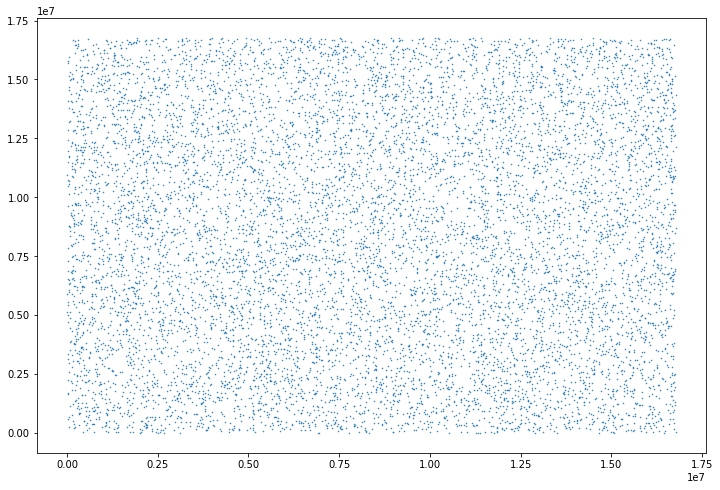

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(values[:-1], values[1:], marker='.', s=1) # all values

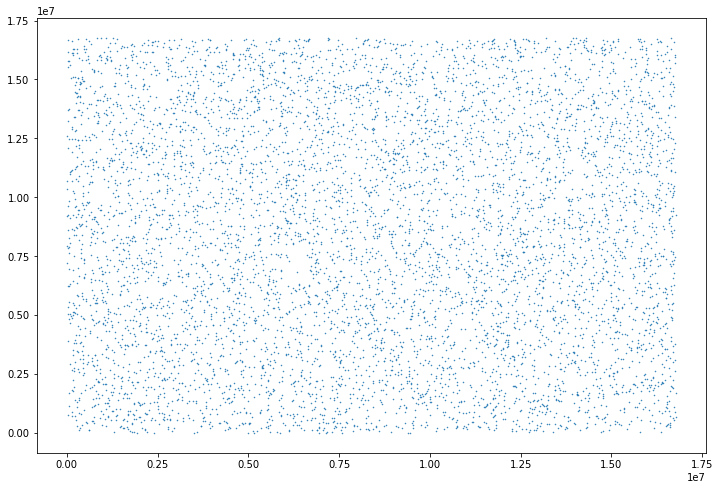

In [47]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(values[:-3356], values[3356:], marker='.', s=1) # just the repeat values

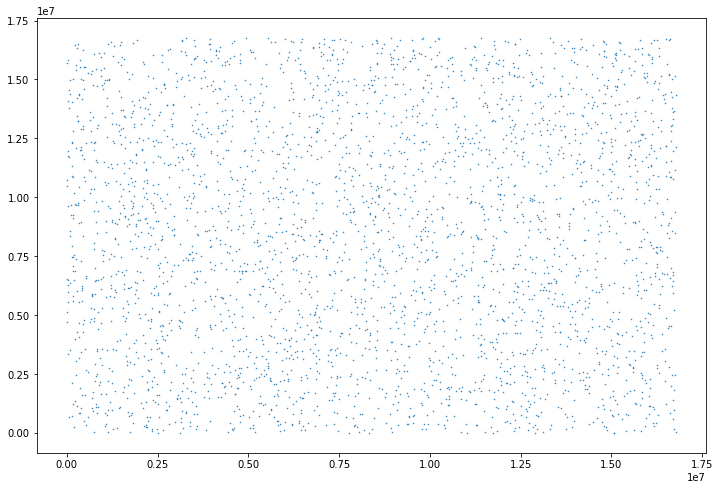

In [48]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(values[:3355], values[1:3356], marker='.', s=1) # just the non-repeating values

What about larger gaps?  Trying scatter plots of $(x_i, x_{i+N})$ for different values of $N$.

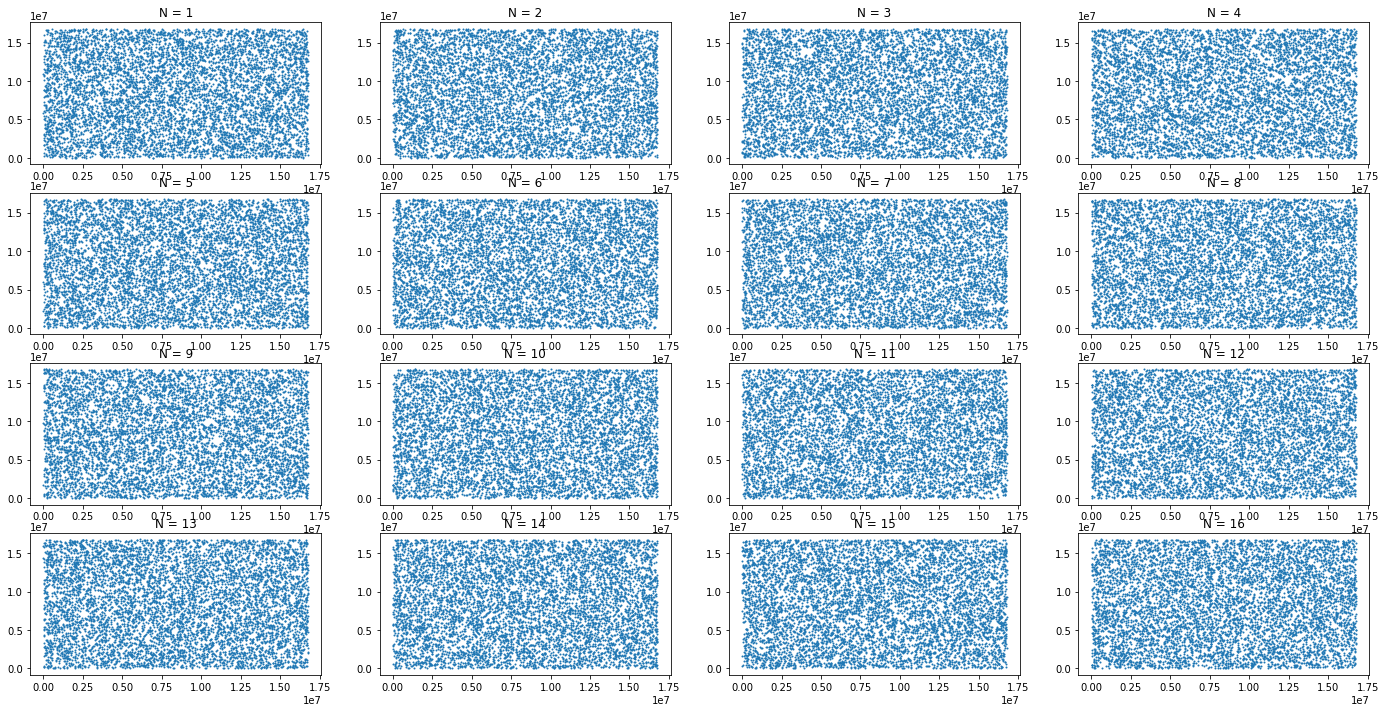

In [74]:
repeat_only = True

if repeat_only:
    data = values[3356:]
else:
    data = values[:]

fig, axs = plt.subplots(4,4, figsize=(24,12))
axs = axs.flatten()


for i in range(len(axs)):
    N = i + 1
    axs[i].scatter(data[:-N], data[N:], marker='o', s=1)
    axs[i].set_title(f'N = {N}')

## It appears that N=4 has some distinct NW&lt;-&gt;SE banding:-

Text(0.5, 1.0, 'N = 4')

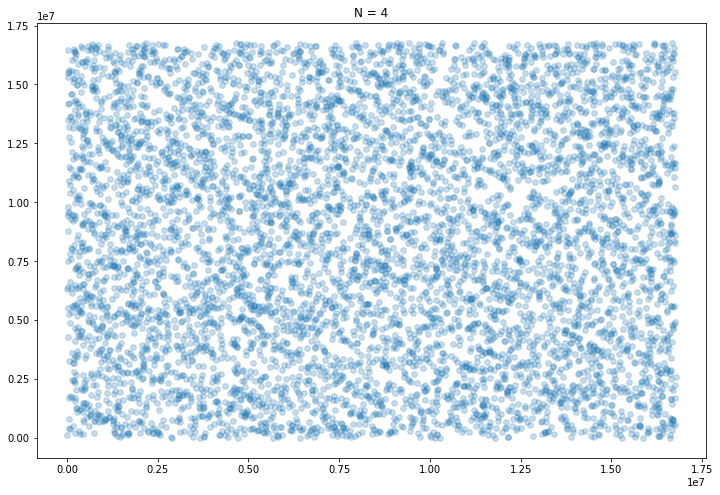

In [85]:
fig, ax = plt.subplots(figsize=(12,8))

offset = 4
ax.scatter(data[:-offset], data[offset:], marker='o', s=32, alpha=0.25)
ax.set_title(f'N = {offset}')

## ACF plots

In [86]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

C:\Users\MarkOakden\Anaconda3\envs\dspython36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


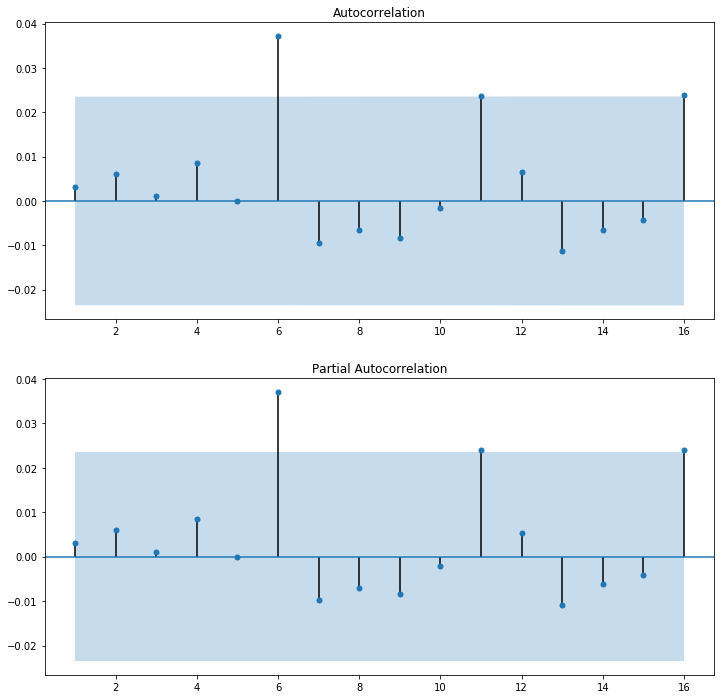

In [108]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,12), squeeze=True)
plot_acf(data, zero=False, lags=16, ax=ax[0])
plot_pacf(data, zero=False, lags=16, ax=ax[1]);

So, interestingly, the ACF plot shows lags of 6, 11 and 16 as more correlated than 4, although none of those is as obvious by eye in the scatter plots.